## Setup

We begin by importing our dependencies.

In [5]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

import time
from random import random

Set our seed and other configurations for reproducibility.

In [6]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
PATH = './cifar_net.pth'

## Dataset

We load our MNIST dataset using the `torchvision` package. 

In [7]:
from model import *
from data import *
from pre_processing import *

In [8]:
batch_size = 1024
dataset = Loader(batch_size=batch_size)
trainloader = dataset.trainloader

def examples(trainloader):
    # get some random training images
    dataiter = iter(trainloader)
    images, _ = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images[:4]))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


print('Examples:')
# examples(trainloader)

Wait for both datasets to be downloaded and verified.
Files already downloaded and verified
Files already downloaded and verified
Examples:


## Autoencoder

An autoencoder is a type of neural network that finds the function mapping the features x to itself. This objective is known as reconstruction, and an autoencoder accomplishes this through the following process: (1) an encoder learns the data representation in lower-dimension space, i.e. extracting the most salient features of the data, and (2) a decoder learns to reconstruct the original data based on the learned representation by the encoder.

We define our autoencoder class with fully connected layers for both its encoder and decoder components.

Before using our defined autoencoder class, we have the following things to do:
    1. We configure which device we want to run on.
    2. We instantiate an `AE` object.
    3. We define our optimizer.
    4. We define our reconstruction loss.

In [9]:
"""
*******************************************************
****** skip this step if you dont want to train *******
*******************************************************
"""

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
net = AE().to(device)
print('Network:', net)

net.batchSize(batch_size)

if torch.cuda.is_available():
    torch.cuda.empty_cache()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

Network: AE(
  (encoder): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU(inplace=True)
  )
  (latent): Linear(in_features=12800, out_features=10, bias=True)
  (latent2): Linear(in_features=10, out_features=12800, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 6, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(6, 3, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU(inplace=True)
  )
)


We train our autoencoder for our specified number of epochs.

In [6]:
"""
*******************************************************
****** skip this step if you dont want to train *******
*******************************************************
"""
workers = 14

def transformTensor(tensor, epoch):
    # add noise
    images = np.copy(tensor.data.numpy())
    noise_images = batch_gaussian_noise(images,workers,  0, 0.001 * epoch)
    images = np.asarray(noise_images)

    # picked = int(len(images) / 20)
    # warped_images = batch_random_projective_transform(images[:picked], workers, None, True, random_range = (epoch + 1) / 500)
    # images = np.append(noise_images, np.asarray(warped_images), axis=0)
    # np.random.shuffle(images)

    # covert to tensor again
    tensor = torch.from_numpy(images)
    return tensor.to(device, dtype=torch.float)

print("start training")

def train(net, trainloader, NUM_EPOCHS):
    train_loss = []
    start_time = time.time()
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data in trainloader:
            img, _ = data
            img = transformTensor(img, epoch).to(device)
            optimizer.zero_grad()
            outputs = net(img)
            loss = criterion(outputs, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        lossEp = running_loss / len(trainloader)
        train_loss.append(lossEp)
        timePerEpoch = (time.time() - start_time)/(epoch + 1)
        left = timePerEpoch * (NUM_EPOCHS - epoch + 1)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(epoch+1, NUM_EPOCHS, lossEp), ' aprox. ' + str(round(left / 60)) + ' min left')
 
    print('Finished Training')
    elapsed_time = time.time() - start_time
    print('final duration: ' + str(round(elapsed_time / 60)) + 'min')
    return train_loss

train_loss = train(net, dataset.trainloader, 5)
torch.save(net.state_dict(), PATH) 

start training
torch.Size([1024, 32, 20, 20])
torch.Size([4, 3276800])


RuntimeError: size mismatch, m1: [4 x 3276800], m2: [12800 x 10] at C:/cb/pytorch_1000000000000/work/aten/src\THC/generic/THCTensorMathBlas.cu:283

In [7]:
"""
*******************************************************
****** skip this step if you dont want to train *******
*******************************************************
"""

fig, ax = plt.subplots()
ax.plot(train_loss)
ax.set(xlabel='epoch', ylabel='loss')
ax.grid()
plt.draw()

NameError: name 'train_loss' is not defined

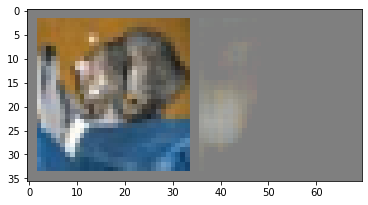

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


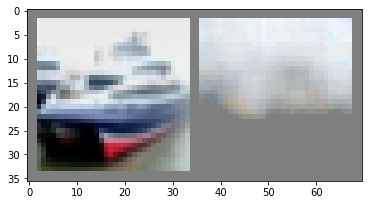

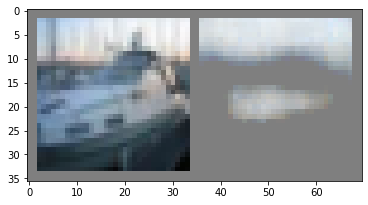

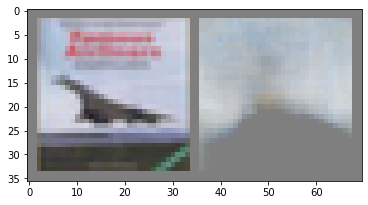

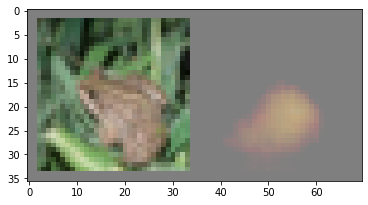

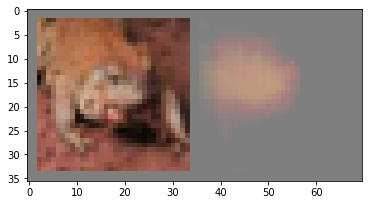

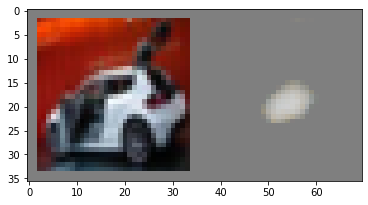

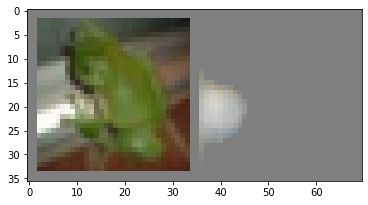

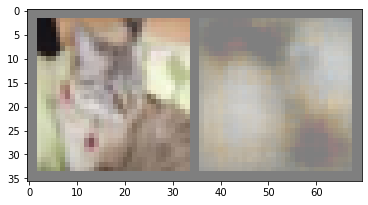

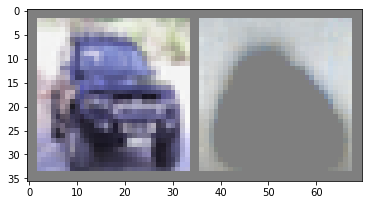

In [10]:
from eval import *
# load test set
dataset_iter = iter(dataset.testloader)
images, classes = dataset_iter.next()
length = len(images)
classNames = dataset.classes

# load network
net2 = AE()
net2.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

# show reconstructed images
outputs = net2(images[:10])

for i in range(10):
    imshow(torchvision.utils.make_grid([images[i], outputs[i]]).detach())


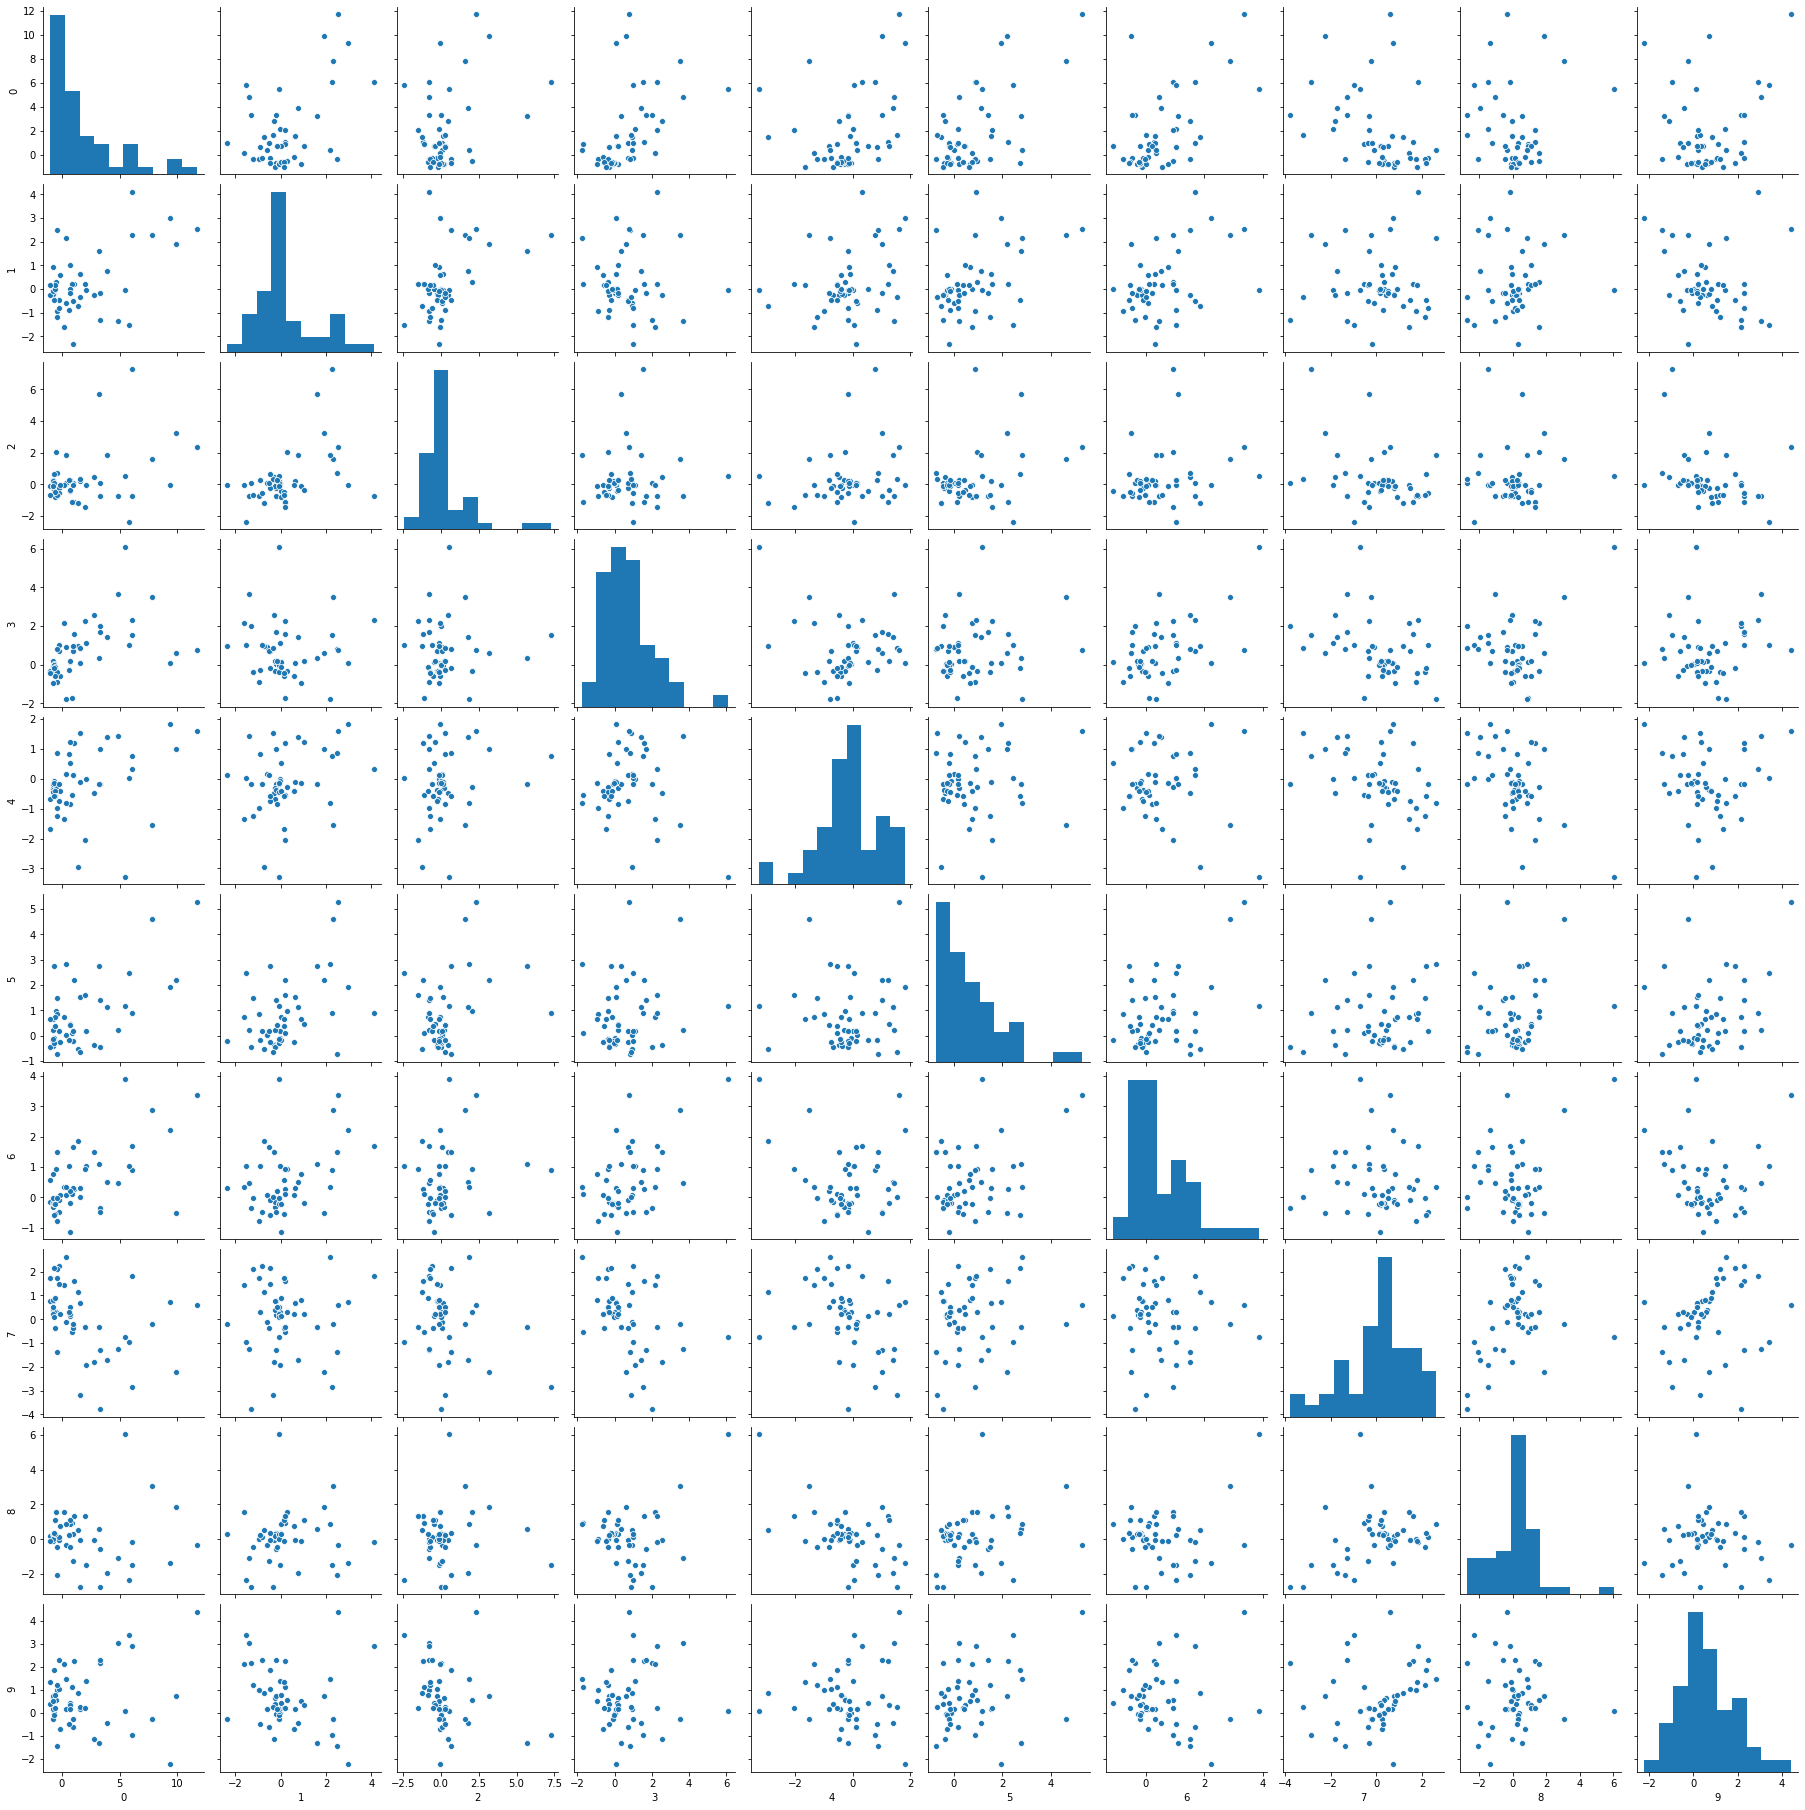

In [11]:
#pairplot

dataset_iter = iter(dataset.testloader)
images, labels = dataset_iter.next()
length = len(images)

net3 = AE()
net3.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

net3.getLatentSpace(True)

outputs3 = net3(images).data.numpy()

outputFrame = pd.DataFrame(outputs3)

sns.pairplot(outputFrame.sample(50))




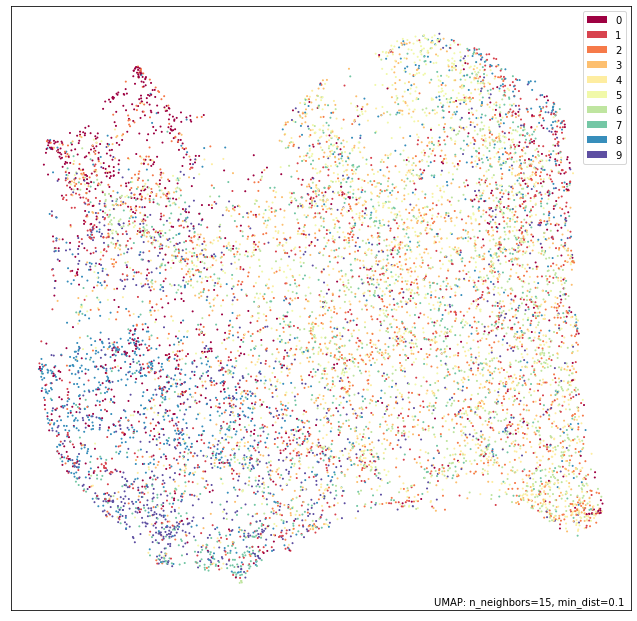

In [41]:
#umap

import umap

umapObj = umap.UMAP().fit(outputs3)
fit.shape                                                        
umap.plot.points(umapObj, labels=classes)



In [8]:
# model should output latent space and not reconstruction
net2.getLatentSpace(True)

# process images
outputs = net2(images).data.numpy()
outputShape = np.shape(outputs)

# flatten latent space
outputs = outputs.flatten().reshape(length, np.prod(outputShape[1:]))




1: car


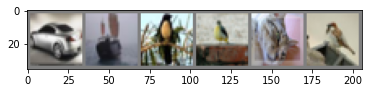

closest: bird: 3,   car: 1,   cat: 1,   ship: 1,    (accuracy: 0/5)


2: dog


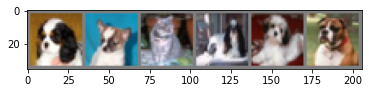

closest: cat: 1,   dog: 5,    (accuracy: 4/5)


3: horse


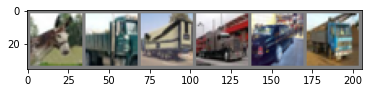

closest: car: 1,   horse: 1,   truck: 4,    (accuracy: 0/5)


4: bird


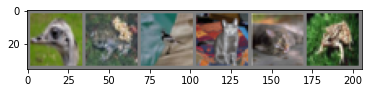

closest: bird: 2,   cat: 2,   frog: 2,    (accuracy: 1/5)


5: horse


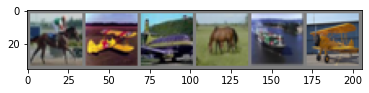

closest: horse: 2,   plane: 3,   ship: 1,    (accuracy: 1/5)


6: frog


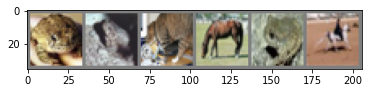

closest: cat: 1,   frog: 3,   horse: 2,    (accuracy: 2/5)


7: deer


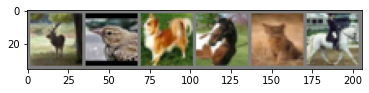

closest: bird: 1,   cat: 1,   deer: 1,   dog: 1,   horse: 2,    (accuracy: 0/5)


8: car


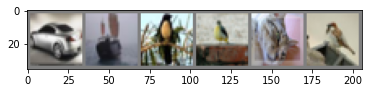

closest: bird: 3,   car: 1,   cat: 1,   ship: 1,    (accuracy: 0/5)


9: horse


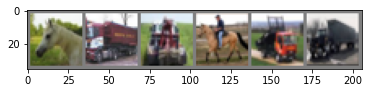

closest: horse: 2,   truck: 4,    (accuracy: 1/5)


10: car


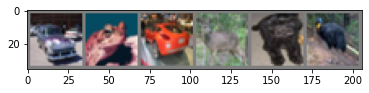

closest: bird: 1,   car: 2,   deer: 1,   dog: 1,   frog: 1,    (accuracy: 1/5)


11: deer


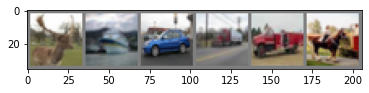

closest: car: 1,   deer: 1,   horse: 1,   ship: 1,   truck: 2,    (accuracy: 0/5)


12: cat


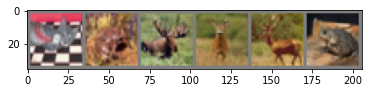

closest: cat: 1,   deer: 3,   frog: 2,    (accuracy: 0/5)


13: deer


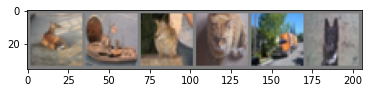

closest: cat: 2,   deer: 1,   dog: 1,   ship: 1,   truck: 1,    (accuracy: 0/5)


14: bird


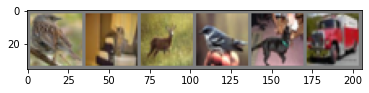

closest: bird: 2,   cat: 1,   deer: 1,   dog: 1,   truck: 1,    (accuracy: 1/5)


15: ship


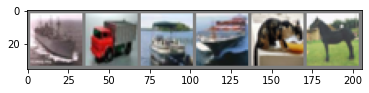

closest: cat: 1,   horse: 1,   ship: 3,   truck: 1,    (accuracy: 2/5)


16: ship


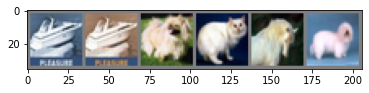

closest: cat: 1,   dog: 2,   horse: 1,   ship: 2,    (accuracy: 1/5)


17: dog


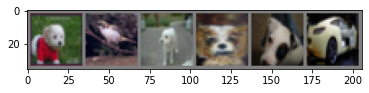

closest: bird: 1,   car: 1,   dog: 4,    (accuracy: 3/5)


18: truck


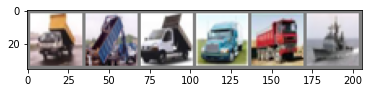

closest: ship: 1,   truck: 5,    (accuracy: 4/5)


19: deer


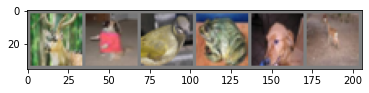

closest: bird: 1,   deer: 2,   dog: 2,   frog: 1,    (accuracy: 1/5)


20: car


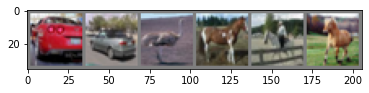

closest: bird: 1,   car: 2,   horse: 3,    (accuracy: 1/5)


In [9]:
# get 20 random images with closest matches
for i in range(20):
    print('\n')
    srcImgId = round(random() * length)
    srcImgClass = classes[srcImgId]
    closest = findNClosest(outputs[srcImgId], outputs, 6)

    acc = 0
    closeImages = []
    closeClasses = []
    for img in closest:
        id = int(img[-1])
        closeImages.append(images[id])
        closeClasses.append(classNames[classes[id]])
        acc += 1 if classes[id] == srcImgClass else 0
    
    # show images
    print(str(i + 1) + ": " + classNames[srcImgClass])
    imshow(torchvision.utils.make_grid(closeImages))

    # show classes
    unique, count = np.unique(closeClasses, return_counts = True) 
    res = ""
    for j in range(len(unique)):
        res += unique[j] + ": " + str(count[j]) + ",   "
    
    print('closest: ' + res + ' (accuracy: ' + str(acc - 1) + '/5)')